In [1]:
import pandas as pd
# en python:
import os
os.environ["https_proxy"] = "http://proxy.fr.cfm.fr:6060"
import numpy as np
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification #, Trainer, TrainingArguments, DataCollatorWithPadding, default_data_collator
from datasets import Dataset
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np 
import faiss 
import tqdm 
import multiprocessing 
import dill as pickle
import datetime
import plotly.express as px

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
import json
# read the config file into a dictionary
with open("/home/yzhong/notebooks/getting_started/config_transformer.json", "r") as f:
    config_ = json.load(f)

print(config_)

{'TRANSLATION_MODEL': 'Helsinki-NLP/opus-mt-zh-en', 'SENTENCE_TRANSFORMER': 'all-MiniLM-L6-v2', 'TRANSLATION_MODEL_ADVANCE': 'alirezamsh/small100', 'model_dir': '/opt/tmp/yzhong/models/'}


In [9]:
DATA_PATH = "/mnt/research-live/user/yzhong/" 

In [ ]:
df_all=pd.read_parquet('/mnt/research-live/user/yzhong/MCD_UN_single_stock.parquet')

In [8]:
df=pd.read_parquet('/mnt/research-live/user/yzhong/bloomberg_news_english_single_stock.parquet')

In [10]:
df.head()

,suid,last_update,eqt_code,analyst,date,daclose,headline,body
0,K9NA111A1I4H,2008-11-01 07:55:49.990,CMB_UN,False,2008-11-01,2008-10-31,Bakrie Sells Bumi Stake to Northstar for $1.3 ...,Adds director's comment in fourth paragraph. P...
1,K9MMZT1A74E9,2008-11-01 13:30:00.000,BA_UN,False,2008-11-01,2008-10-31,Boeing Machinists to Vote on Ending Production...,Boeing Co. machinists will castballots today o...
2,K9NQAG0R00ZM,2008-11-01 13:47:04.680,ORDI_NA,False,2008-11-01,2008-10-31,UBS AG Has 4.89 Percent in Ordina.,
3,K9NR6T0Y6HHE,2008-11-01 14:06:29.830,MEO1V_FH,False,2008-11-01,2008-10-31,Metso Starts Layoff Talks For 384 Workers in T...,
4,K9NSXG1A1I4H,2008-11-01 14:44:04.300,AFA_NA,False,2008-11-01,2008-10-31,French Airline Unions Delay Retirement-Age Str...,Labor unions representing Frenchaviation worke...


In [11]:
df_day = df.groupby(['eqt_code','date']).size().reset_index(name='Count')

In [12]:
df_day

,eqt_code,date,Count
0,000001_C2,2023-04-24,4
1,000001_CH,2009-01-06,3
2,000001_CH,2009-01-12,2
3,000001_CH,2009-01-13,4
4,000001_CH,2009-01-20,1
...,...,...,...
5488958,Z_US,2023-02-27,2
5488959,Z_US,2023-03-01,2
5488960,Z_US,2023-04-18,1
5488961,Z_US,2023-04-20,2


In [3]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.strftime('%Y-%m-%d')

In [4]:
df_day = df.groupby('date').size().reset_index(name='Count')

In [5]:
df_day['Month']=df_day['date'].dt.strftime('%Y-%m')

In [15]:
import numpy as np
import pandas as pd
import plotly.express as px

# Create a list of unique eqt_codes
eqt_codes = df_day['eqt_code'].unique()

# Create a dictionary to store data frames for each eqt_code
data_dict = {}
for eqt_code in eqt_codes:
    data_dict[eqt_code] = df_day[df_day['eqt_code'] == eqt_code]

# Create a list of drop-down menu options
dropdown_options = [{'label': 'All Data', 'value': 'All Data'}]
for eqt_code in eqt_codes:
    dropdown_options.append({'label': eqt_code, 'value': eqt_code})

# Create the figure
fig = px.bar(df_day, x='date', y='Count')

dfbut = (
    (df_day["date"] + pd.offsets.MonthBegin(-1))
    .drop_duplicates()
    .to_frame()
    .assign(
        label=lambda d: d["date"].dt.strftime("%b-%Y"),
        start=lambda d: (d["date"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"),
        end=lambda d: d["start"].shift(-1),
    )
    .fillna((df["date"].max() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"))
)


# Create the drop-down menu
fig.update_layout(
    updatemenus=[
        {
            'buttons': [
                {
                    'label': r[1]['label'],
                    'method': 'relayout',
                    'args': [{'xaxis': {'range': [r[1]['start'], r[1]['end']]}}],
                }
                for r in dfbut.iterrows()
            ]
        },
        {
            'buttons': [{'label': 'All Data', 'method': 'relayout', 'args': [{'xaxis': {'range': []}}]}],
            'y': 0.8,
            'type': 'buttons'
        },
        {
            'buttons': [
                {
                    'method': 'update',
                    'args': [{'visible': [eqt_code == 'All Data' for eqt_code in eqt_codes]}],
                    'label': 'All Data'
                }
            ] + [
                {
                    'method': 'update',
                    'args': [{'visible': [eqt_code == value for eqt_code in eqt_codes]}],
                    'label': value
                }
                for value in eqt_codes
            ],
            'direction': 'down',
            'showactive': True,
            'x': 0.1,
            'y': 0.9
        }
    ]
)

# Add the traces for each eqt_code
for eqt_code in eqt_codes:
    data = data_dict[eqt_code]
    trace = px.bar(data, x='date', y='Count', color='eqt_code', color_discrete_sequence=['blue'])
    trace.update_traces(visible=False, selector={'name': eqt_code})
    fig.add_traces(trace.data)

# Set the initial visibility of the traces
fig.update_traces(visible=True, selector={'name': 'All Data'})

fig.show()


KeyboardInterrupt: 

## Plot the volume of data monthly

In [27]:
import numpy as np
import pandas as pd
import plotly.express as px


fig = px.bar(df_day, x="date", y="Count")

dfbut = (
    (df_day["date"] + pd.offsets.MonthBegin(-1))
    .drop_duplicates()
    .to_frame()
    .assign(
        label=lambda d: d["date"].dt.strftime("%b-%Y"),
        start=lambda d: (d["date"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"),
        end=lambda d: d["start"].shift(-1),
    )
    .fillna((df["date"].max() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"))
)

# build buttons to filter by month
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": r[1]["label"],
                    "method": "relayout",
                    "args": [{"xaxis": {"range": [r[1]["start"], r[1]["end"]]}}],
                }
                for r in dfbut.iterrows()
            ]
        },
        {"buttons":[{"label":"All data", "method":"relayout","args":[{"xaxis":{"range":[]}}]}],"y":.8,"type":"buttons"}
    ]
)


In [7]:
import numpy as np
import pandas as pd
import plotly.express as px

# Define color map dictionary
color_map = {"All data": "darkblue"}

fig = px.bar(df_day, x="date", y="Count", color="Month",
             color_discrete_map=color_map)
dfbut = (
    (df_day["date"] + pd.offsets.MonthBegin(-1))
    .drop_duplicates()
    .to_frame()
    .assign(
        label=lambda d: d["date"].dt.strftime("%b-%Y"),
        start=lambda d: (d["date"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"),
        end=lambda d: d["start"].shift(-1),
    )
    .fillna((df["date"].max() - pd.Timestamp("1970-01-01")) // pd.Timedelta("1ms"))
)
# build buttons to filter by month
fig.update_layout(
    updatemenus=[
        {
            "buttons": [
                {
                    "label": r[1]["label"],
                    "method": "relayout",
                    "args": [{"xaxis": {"range": [r[1]["start"], r[1]["end"]]}}],
                }
                for r in dfbut.iterrows()
            ]
        },
        {"buttons":[{"label":"All data", "method":"relayout","args":[{"xaxis":{"range":[]}}]}],"y":.8,"type":"buttons"}
    ]
)


In [207]:
grouped = df.groupby('date').size().reset_index(name="count")

In [2]:
import pandas as pd
import plotly.express as px

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import dash
import dash_core_components as dcc
import dash_html_components as html

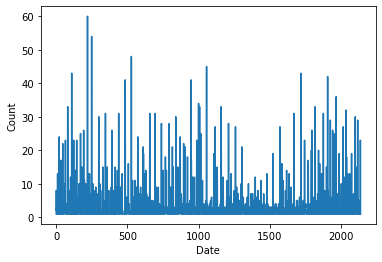

In [209]:
import matplotlib.pyplot as plt
# group by date and count the number of rows
grouped = df.groupby('date').size().reset_index(name="count")

# plot the distribution
plt.plot(grouped.index, grouped['count'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

In [7]:
df_m=df[df.eqt_code=='MCD_UN'].sort_values(by=['last_update'], ascending=True).reset_index(drop=True)

In [203]:
with open('/mnt/research-live/user/yzhong/MCD_UN.txt', 'w') as f:
    for row in df.itertuples():
        f.write(str(row.last_update) + '\n')
        f.write(str(row.analyst) + '\n')
        f.write(f'headline  {row.headline}' + '\n')
        f.write(str(row.body) + '\n')

In [13]:
MODEL_ID = config_['SENTENCE_TRANSFORMER']
model = SentenceTransformer(MODEL_ID,device='cuda',cache_folder=config_['model_dir'] )
# Use the map method to apply the mapping function to the dataset in batches
batch_size =256*4

In [25]:
def sentence_tokenization(batch, text='translation'):
   # inputs = tokenizer(batch[text], padding= True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        embeddings = model.encode(batch[text])
    return {'embeddings': embeddings}


In [22]:
ds = Dataset.from_dict({
                "id": df_m.index,
                "headline": df_m["headline"],
                'length': df_m["headline"].map(lambda x: len(x)) })

In [23]:
ds = ds.map(lambda x: sentence_tokenization(x, text='headline'), batched=True, batch_size=batch_size).sort('id')

Parameter 'function'=<function <lambda> at 0x7f69869f5670> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [27]:
df_m['embeddings']=ds['embeddings']

In [50]:
# Explode the "embeddings" column into separate rows
df = df_m.explode('embeddings')
df['index'] = df.groupby(level=0).cumcount()

# Pivot the DataFrame to create separate columns for each element
df = df.pivot(index=['suid','last_update','eqt_code','headline'],columns='index', values='embeddings')

In [39]:
# Define the number of elements in each list
num_elements = len(df_m['embeddings'][0])

# Use apply() with a lambda function to create a new DataFrame with separate columns for each element
new_df = df_m['embeddings'].apply(lambda x: pd.Series(x, index=[f'embedding_{i}' for i in range(num_elements)]))

# Concatenate the new DataFrame with the original DataFrame
df = pd.concat([df_m, new_df], axis=1)

# Drop the original "embeddings" column
df.drop('embeddings', axis=1, inplace=True)

In [34]:
dates=df_m['last_update'].dt.date

In [29]:
df_m.to_parquet('/mnt/research-live/user/yzhong/MCD_UN_single_stock.parquet')

In [141]:
df=pd.read_parquet('/mnt/research-live/user/yzhong/MCD_UN_single_stock.parquet')

In [13]:
# Convert the embeddings column to a NumPy array
embeddings_array = np.array(df['embeddings'].tolist())
# Normalize the embeddings
normalized_embeddings = (embeddings_array - embeddings_array.mean()) / embeddings_array.std()
# Replace the embeddings column with the normalized embeddings
df['embeddings'] = normalized_embeddings.tolist()

In [77]:
all_distances = dict() 
all_indexes = dict()
for idx in tqdm.tqdm(list(range(n_days, len(unique_dates)))): 
    obs_date = unique_dates[idx] 
    #search_dates = unique_dates[idx - n_days:idx] 
    search_dates=[obs_date - datetime.timedelta(days=i) for i in range(n_days)]

    obs_df = df.loc[df_m['date'] == obs_date]  # <- dateframe we want to search
    search_df = df.loc[df_m['date'].isin(search_dates)]  # <- dateframe we want to query

    obs_embeddings = obs_df.loc[:, 'embeddings'].values 
    search_embeddings = search_df.loc[:, 'embeddings'].values

    similarity_computer = faiss.IndexFlatL2(len(df['embeddings'][0])) 
    similarity_computer.add(np.vstack(search_embeddings).astype('float32'))
    distances, indexes = similarity_computer.search(np.vstack(obs_embeddings).astype('float32'), n + 1)
    all_distances.update( 
    dict(zip(obs_df.index, distances)) 
    )
    matched_indexes = np.where(indexes != -1, search_df.index.values[indexes], None) 
    all_indexes.update(dict(zip(obs_df.index.values, matched_indexes)))

100%|██████████| 4/4 [00:00<00:00, 449.96it/s]


In [108]:
distances, indexes = similarity_computer.search(np.vstack(obs_embeddings).astype('float32'), n + 1)

In [110]:
rounded_arr = np.round(distances, 2)
rounded_arr 

/home/yzhong/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


array([[  0.  , 540.35, 697.16,    inf]], dtype=float32)

In [109]:
distances

array([[0.0000000e+00, 5.4035193e+02, 6.9716052e+02, 3.4028235e+38]],
      dtype=float32)

In [142]:
embeddings_vectors=np.array(df['embeddings'].tolist()).astype('float32')
ids=df.index.values.astype(np.int64)

In [143]:
faiss.normalize_L2(np.array(df['embeddings'].tolist()).astype('float32'))

In [144]:
index=faiss.IndexFlatIP(384)
index=faiss.IndexIDMap(index)
index.add_with_ids(embeddings_vectors,ids)

In [145]:
k_nearest=2
search_query=embeddings_vectors
faiss.normalize_L2(search_query)

In [146]:
similarities,similarities_ids=index.search(search_query,k=k_nearest)

In [148]:
similarities=np.around(np.clip(similarities,0,1),decimals=4)

In [149]:
similarities

array([[1.    , 0.7873],
       [1.    , 0.8559],
       [1.    , 0.9389],
       ...,
       [1.    , 0.7261],
       [1.    , 0.95  ],
       [1.    , 0.9982]], dtype=float32)

In [131]:
obs_embeddings = df.loc[1:10, 'embeddings'].values 
obs_vectors=np.vstack(obs_embeddings).astype('float32')
len(obs_vectors)

10

In [132]:
distances

array([[0.0000000e+00, 5.4035193e+02, 6.9716052e+02, 3.4028235e+38]],
      dtype=float32)

In [134]:
quantile = np.quantile(distances, 0.95)
quantile

2.892399946427494e+38

In [ ]:
def get_quantile_distance(df, n_days=1, mode="cosine",threshold=0.95,dim=384,ncores = 1):
    assert mode in ["l2", "cosine"] 
    dates=df.date
    
    assert len(df) == len(dates), "dates series have to be same length as df" 

    unique_dates = list(sorted(np.unique(dates)))


    all_quantile = dict() 

    for idx in tqdm.tqdm(list(range(n_days, len(unique_dates)))): 
        obs_date = unique_dates[idx] 
        #search_dates = unique_dates[idx - n_days:idx] 
        search_dates=[obs_date - datetime.timedelta(days=i) for i in range(n_days)]

        #obs_df = df.loc[df['date'] == obs_date]  # <- dateframe we want to search
        search_df = df.loc[df['date'].isin(search_dates)]  # <- dateframe we want to query

        #obs_embeddings = obs_df.loc[:, 'embeddings'].values 
        #obs_vectors=np.vstack(obs_embeddings).astype('float32')
        search_embeddings = search_df.loc[:, 'embeddings'].values
        search_vectors=np.vstack(search_embeddings).astype('float32')
        ids=search_embeddings.index.values.astype(np.int64)

        #faiss.normalize_L2(obs_vectors)
        faiss.normalize_L2(search_vectors)

    
        if mode == "l2": 
            index = faiss.IndexFlatL2(dim) 
        elif mode == "cosine": 
            index = faiss.IndexFlatIP(dim) 
        else: 
            print(f"Unknown mode {mode}. Defaulting to L2 distance") 

            index = faiss.IndexFlatL2(dim)
        index.add_with_ids(search_vectors,ids)

        n=len(search_vectors)


        if ncores == 1: 
            distances, _ = index.search(search_vectors, n)

            all_distances.update( 
                dict(zip(obs_df.index, distances)) 
                )
            
            # put none if the index == -1, which means no match
            matched_indexes = np.where(indexes != -1, search_df.index.values[indexes], None) 
            # put the index of the dataframe

            all_indexes.update(
                dict(zip(obs_df.index.values, matched_indexes))
                )
        
    
    






In [169]:
distances_df, neighbors_index_df=get_rolling_closest_neighbors_index(df, n_days=1, n=3, mode="cosine", ncores=1)

100%|██████████| 2137/2137 [00:03<00:00, 640.71it/s]


In [172]:
def get_rolling_closest_neighbors_index(df, n_days, n=4, mode="l2", ncores=1,max_gap_days=False):
    assert mode in ["l2", "cosine"] 
    dates=df.date

    assert len(df) == len(dates), "dates series have to be same length as df" 

    unique_dates = list(sorted(np.unique(dates)))

    "This part normalized the embeddings, the embeddings was saved as numpy array in column embedding and it will be saved as list " 
    
    all_distances = dict() 
    all_indexes = dict()

    for idx in tqdm.tqdm(list(range(n_days, len(unique_dates)))): 
        obs_date = unique_dates[idx]
        if max_gap_days=False:     
            search_dates=[obs_date - datetime.timedelta(days=i) for i in range(n_days)]
        else: 
            search_dates = unique_dates[idx - n_days:idx] 

        obs_df = df.loc[df['date'] == obs_date]  # <- dateframe we want to search
        search_df = df.loc[df['date'].isin(search_dates)]  # <- dateframe we want to query

        obs_embeddings = obs_df.loc[:, 'embeddings'].values
        obs_vectors= np.vstack(obs_embeddings).astype('float32')
        search_embeddings = search_df.loc[:, 'embeddings'].values
        search_vectors=np.vstack(search_embeddings).astype('float32')
        faiss.normalize_L2(search_vectors)
        faiss.normalize_L2(obs_vectors)

    
        if mode == "l2": 
            similarity_computer = faiss.IndexFlatL2(len(df['embeddings'][0])) 
        elif mode == "cosine": 
            similarity_computer = faiss.IndexFlatIP(len(df['embeddings'][0])) 
        else: 
            print(f"Unknown mode {mode}. Defaulting to L2 distance") 

            similarity_computer = faiss.IndexFlatL2(len(df['embeddings'][0]))

        similarity_computer.add(search_vectors)


        if ncores == 1: 
            distances, indexes = similarity_computer.search(obs_vectors, n + 1)
            if mode =='cosine':
                distances=np.around(np.clip(distances,0,1),decimals=4)

            all_distances.update( 
                dict(zip(obs_df.index, distances)) 
                )
            
            # put none if the index == -1, which means no match
            matched_indexes = np.where(indexes != -1, search_df.index.values[indexes], None) 
            # put the index of the dataframe

            all_indexes.update(
                dict(zip(obs_df.index.values, matched_indexes))
                )
            
        else: 
            pool = multiprocessing.Pool(processes=ncores)
            distances, indexes = pool.map(similarity_computer.search, 
                                          [[df.iloc[i].to_frame().T.values, n + 1] for i in idx])
            
            all_distances.update( 
                dict(zip(obs_df.index, distances)) 
                ) 
            matched_indexes = np.where(indexes != -1, search_df.index.values[indexes], None) 

            all_indexes.update(
                dict(zip(obs_df.index.values, matched_indexes))
                )

    # Building DataFrame from dict
    distances_df = pd.DataFrame(all_distances).T

    neighbors_index_df = pd.DataFrame(all_indexes).T
    
    return distances_df, neighbors_index_df

In [178]:
len(distances_df.columns)

4

In [196]:
def get_neighbours_dataframe(distances_df, neighbors_index_df, df):
    # drop column 0 from distances_df
    distances_df = distances_df.iloc[:, 1:].rename(columns=lambda x: f"distance_{x}")
    neighbors_index_df = neighbors_index_df.iloc[:, 1:]
    # create a new dataframe with the same index as neighbors_index_df
    new_df = pd.DataFrame(index=neighbors_index_df.index)
    # iterate over each column of neighbors_index_df
    for col in neighbors_index_df.columns:
        # create new column names
        col_headline = 'headline_' + str(col)
        col_last_update = 'last_update_' + str(col)
        col_suid = 'suid_' + str(col)
        
        # get the column values from neighbors_index_df
        col_values = neighbors_index_df[col]
        
        # generate the new column values using a list comprehension
        headline_values = [df.loc[val]['headline'] if not pd.isna(val) else None for val in col_values]
        last_update_values = [df.loc[val]['last_update'] if not pd.isna(val) else None for val in col_values]
        suid_values = [df.loc[val]['suid'] if not pd.isna(val) else None for val in col_values]
        
        # add the new columns to the new dataframe
        new_df = new_df.assign(**{col_headline: headline_values, col_last_update: last_update_values, col_suid: suid_values})
    
    # concatenate the distances_df with the new_df
    merged_df = pd.concat([df, pd.concat([distances_df, new_df], axis=1)], axis=1)
    return merged_df

    

In [197]:
df_merge=get_neighbours_dataframe(distances_df, neighbors_index_df, df)

In [202]:
with open('/mnt/research-live/user/yzhong/MCD_UN_compare.txt', 'w') as f:
    for row in df_merge.itertuples():
        f.write(str(row.date) + '\n')
        f.write(str(row.analyst) + '\n')
        f.write(f'headline  {row.headline}' + '\n')
        f.write(f'distance_1 {round(row.distance_1, 2)}  {row.headline_1}' + '\n')
        f.write(f'distance_2 {round(row.distance_2, 2)}  {row.headline_2}' + '\n')
        f.write(f'distance_3 {round(row.distance_3, 2)}   {row.headline_3}' + '\n')

In [198]:
df_merge

,suid,last_update,eqt_code,analyst,date,daclose,headline,body,embeddings,distance_1,...,distance_3,headline_1,last_update_1,suid_1,headline_2,last_update_2,suid_2,headline_3,last_update_3,suid_3
0,K9YYKH0D9L3G,2008-11-07 15:19:29.980,MCD_UN,True,2008-11-07,2008-11-07,MCDONALD'S MAY REPORT U.S. SALES GAIN OF 4% IN...,,"[0.0024996071588248014, -0.1004284918308258, -...",NaN,...,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN
1,KA4C0V0D9L36,2008-11-10 12:58:07.500,MCD_UN,False,2008-11-10,2008-11-10,MCDONALD'S CONTINUES TO DELIVER - GLOBAL COMP ...,PR Newswire: U.S. press release is accessible ...,"[-0.004011599346995354, -0.09672773629426956, ...",0.8013,...,0.7666,MCDONALD'S OCT EUROPE COMP SALES UP 9.8%.,2008-11-10 12:58:29.740,KA4C1H0D9L34,MCDONALD'S OCT. ASIA/PACIFIC COMP SALES UP 11.5%.,2008-11-10 12:58:35.480,KA4C1N0D9L34,MCDONALD'S OCT U.S. COMP SALES UP 5.3%.,2008-11-10 12:58:22.030,KA4C1A0D9L34
2,KA4C110D9L35,2008-11-10 12:58:13.370,MCD_UN,False,2008-11-10,2008-11-10,MCDONALD'S OCT SAME-STORE SALES UP 8.2%.,PR Newswire: U.S. press release is accessible ...,"[0.0035450521390885115, -0.10203630477190018, ...",0.8445,...,0.7946,MCDONALD'S OCT U.S. COMP SALES UP 5.3%.,2008-11-10 12:58:22.030,KA4C1A0D9L34,MCDONALD'S OCT EUROPE COMP SALES UP 9.8%.,2008-11-10 12:58:29.740,KA4C1H0D9L34,McDonald's October Sales Rise 8.2 Percent on D...,2008-11-10 13:01:54.200,KA4C760UQVIQ
3,KA4C1A0D9L34,2008-11-10 12:58:22.030,MCD_UN,False,2008-11-10,2008-11-10,MCDONALD'S OCT U.S. COMP SALES UP 5.3%.,PR Newswire: U.S. press release is accessible ...,"[0.013068266212940216, -0.12741690874099731, 0...",0.8868,...,0.8445,MCDONALD'S OCT EUROPE COMP SALES UP 9.8%.,2008-11-10 12:58:29.740,KA4C1H0D9L34,MCDONALD'S OCT. ASIA/PACIFIC COMP SALES UP 11.5%.,2008-11-10 12:58:35.480,KA4C1N0D9L34,MCDONALD'S OCT SAME-STORE SALES UP 8.2%.,2008-11-10 12:58:13.370,KA4C110D9L35
4,KA4C1H0D9L34,2008-11-10 12:58:29.740,MCD_UN,False,2008-11-10,2008-11-10,MCDONALD'S OCT EUROPE COMP SALES UP 9.8%.,PR Newswire: U.S. press release is accessible ...,"[0.025935335084795952, -0.0862438902258873, 0....",0.8868,...,0.8097,MCDONALD'S OCT U.S. COMP SALES UP 5.3%.,2008-11-10 12:58:22.030,KA4C1A0D9L34,MCDONALD'S OCT. ASIA/PACIFIC COMP SALES UP 11.5%.,2008-11-10 12:58:35.480,KA4C1N0D9L34,MCDONALD'S OCT SAME-STORE SALES UP 8.2%.,2008-11-10 12:58:13.370,KA4C110D9L35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6820,RTO9HEDWX2PV,2023-04-25 13:00:50.499,MCD_UN,False,2023-04-25,2023-04-25,MCDONALD'S: MORE RESISTANCE TO HIGHER PRICES I...,,"[0.038969628512859344, -0.04762502387166023, 0...",0.6342,...,0.6140,MCDONALD'S: STAFFING SITUATION IMPROVING AROUN...,2023-04-25 12:57:32.040,RTO9BWDWX2PS,McDonald’s Tops Sales Estimates as Diners Shru...,2023-04-25 11:03:51.943,RTN09VDWX2PW,MCDONALD'S MARKET SHARE IMPROVING ACROSS ALL I...,2023-04-25 13:18:50.407,RTOABEDWLU69
6821,RTOA5ZDWLU6B,2023-04-25 13:15:35.382,MCD_UN,False,2023-04-25,2023-04-25,MCDONALD'S SAYS DELIVERY GROWTH HAS SLOWED.,,"[0.027442051097750664, -0.06776246428489685, 0...",0.5766,...,0.4977,MCDONALD'S: 'SLIGHT DECREASE' IN UNITS PER TRA...,2023-04-25 13:00:28.743,RTO9GSDWLU6G,MCDONALD'S: STAFFING SITUATION IMPROVING AROUN...,2023-04-25 12:57:32.040,RTO9BWDWX2PS,"MCDONALD'S 1Q US COMP SALES +12.6%, EST. +7.54%.",2023-04-25 11:00:22.423,RTNZSI6RV5DU
6822,RTOABEDWLU69,2023-04-25 13:18:50.407,MCD_UN,False,2023-04-25,2023-04-25,MCDONALD'S MARKET SHARE IMPROVING ACROSS ALL I...,,"[0.01917552947998047, -0.07925669848918915, 0....",0.6140,...,0.5872,MCDONALD'S: MORE RESISTANCE TO HIGHER PRICES I...,2023-04-25 13:00:50.499,RTO9HEDWX2PV,MCDONALD'S SEES YR OPERATING MARGIN% ABOUT 45%.,2023-04-25 11:06:08.440,RTO468CAB9Q8,"MCDONALD'S 1Q COMP SALES +12.6%, EST. +8.19%.",2023-04-25 11:00:22.441,RTO09FDWRGG0
6823,RTOBDNDWLU68,2023-04-25 13:43:47.126,MCD_UN,False,2023-04-25,2023-04-25,McDonald’s Tops Sales Estimates as Diners Shru...,McDonald’s Corp. reported first-quartersales a...,"[-0.007457631640136242, -0

In [195]:
distances_df, neighbors_index_df=get_rolling_closest_neighbors_index(df_m, dates, n_days=3, n=4, mode="l2", norm=False, ncores=1)

100%|██████████| 2135/2135 [00:03<00:00, 556.30it/s]


In [6]:
len(df[df.eqt_code=='AAPL_UQ'])

24394